#### Referência: https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e

In [96]:
import h5py
import numpy as np
from tensorflow import keras
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [48]:
filename = 'food_c101_n10099_r32x32x3.h5'

with h5py.File(filename, 'r') as f:
    # List all groups
    images = list(f.keys())[2]
    names = list(f.keys())[1]
    category = list(f.keys())[0]

    # Get the data
    #print(f[a_group_key][0])
    print(list([(i, name) for i, name in enumerate(f[names])]))
    data = np.array(f[images])
    outputs_data = np.array(f[category])

[(0, b'apple_pie'), (1, b'baby_back_ribs'), (2, b'baklava'), (3, b'beef_carpaccio'), (4, b'beef_tartare'), (5, b'beet_salad'), (6, b'beignets'), (7, b'bibimbap'), (8, b'bread_pudding'), (9, b'breakfast_burrito'), (10, b'bruschetta'), (11, b'caesar_salad'), (12, b'cannoli'), (13, b'caprese_salad'), (14, b'carrot_cake'), (15, b'ceviche'), (16, b'cheese_plate'), (17, b'cheesecake'), (18, b'chicken_curry'), (19, b'chicken_quesadilla'), (20, b'chicken_wings'), (21, b'chocolate_cake'), (22, b'chocolate_mousse'), (23, b'churros'), (24, b'clam_chowder'), (25, b'club_sandwich'), (26, b'crab_cakes'), (27, b'creme_brulee'), (28, b'croque_madame'), (29, b'cup_cakes'), (30, b'deviled_eggs'), (31, b'donuts'), (32, b'dumplings'), (33, b'edamame'), (34, b'eggs_benedict'), (35, b'escargots'), (36, b'falafel'), (37, b'filet_mignon'), (38, b'fish_and_chips'), (39, b'foie_gras'), (40, b'french_fries'), (41, b'french_onion_soup'), (42, b'french_toast'), (43, b'fried_calamari'), (44, b'fried_rice'), (45, b'

In [49]:
def bool_to_int(classifiers):
    n_examples, m_classes = classifiers.shape
    classifier_int = []
    for item in classifiers:
        j_list = [int(a) for a in item]
        classifier_int.append(j_list)
    return np.array(classifier_int)

def foods_to_vegan_classifier(classifiers):
    vegans = list([5, 33, 36, 40, 51, 54, 57, 64, 88])
    ovo_lacto = list([0, 2, 6, 8, 10, 11, 12, 13, 14, 16, 17, 21, 22, 23, 27, 29, 30, 31, 42, 46, 47, 48, 49, 56, 58,  62, 63, 67, 68,   72, 76, 82, 83, 84, 85, 94, 98, 100])
    meat = list([1, 3, 4, 7, 9, 15, 18, 19, 20, 24, 25, 26, 28, 32, 34, 35, 37, 38, 39, 41, 44, 45, 50, 52, 54, 55, 59, 60, 61, 65, 66, 69, 70, 71,  73, 74, 75, 77, 78, 79, 80, 81,  86, 87, 89, 90, 91, 92, 93, 95, 96, 97, 99])
    list_of_pos = []
    n_examples, m_classes = classifiers.shape
    for item in classifiers:
        for i, a in enumerate(item):
            if a == 1:
                list_of_pos.append(i)
    new_output = []
    for item in list_of_pos:
        if item in vegans:
            new_output.append([1, 0, 0])
        elif item in ovo_lacto:
            new_output.append([0,1,0])
        else:
            new_output.append([0,0,1])
    return np.array(new_output)

outputs_data = bool_to_int(outputs_data)
classes = foods_to_vegan_classifier(outputs_data)

In [83]:
#Train Data
train = data[:]
train_labels = classes[:]
train.shape

(10099, 32, 32, 3)

In [84]:
#Image shape
shape = train[0].shape

In [85]:
#Normalize
train = train/255
valid = valid/255

In [86]:
#Model
model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=shape))
model.add(Conv2D(64, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [87]:
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

In [88]:
# reduz o parâmetro de learning rate se não houver 
# melhoras em determinado número de epocas
# útil para encontrar o mínimo global.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

batch_size = 32
epochs = 10

In [89]:
history = model.fit(train,
                        train_labels,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_split=0.2,
                        verbose = 1,
                        callbacks=[learning_rate_reduction])

history_dict = history.history

Train on 8079 samples, validate on 2020 samples
Epoch 1/10
8079/8079 [==============================] - 79s 10ms/step - loss: 0.9491 - accuracy: 0.5114 - val_loss: 0.8968 - val_accuracy: 0.5446
Epoch 2/10


C:\Users\marinhog\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


8079/8079 [==============================] - 82s 10ms/step - loss: 0.9262 - accuracy: 0.5236 - val_loss: 0.8941 - val_accuracy: 0.5450
Epoch 3/10
8079/8079 [==============================] - 80s 10ms/step - loss: 0.9219 - accuracy: 0.5236 - val_loss: 0.8887 - val_accuracy: 0.5450
Epoch 4/10
8079/8079 [==============================] - 79s 10ms/step - loss: 0.9122 - accuracy: 0.5268 - val_loss: 0.8708 - val_accuracy: 0.5564
Epoch 5/10
8079/8079 [==============================] - 79s 10ms/step - loss: 0.9061 - accuracy: 0.5291 - val_loss: 0.8882 - val_accuracy: 0.5530
Epoch 6/10
8079/8079 [==============================] - 77s 10ms/step - loss: 0.9022 - accuracy: 0.5305 - val_loss: 0.8694 - val_accuracy: 0.5535
Epoch 7/10
8079/8079 [==============================] - 76s 9ms/step - loss: 0.8954 - accuracy: 0.5343 - val_loss: 0.8809 - val_accuracy: 0.5550
Epoch 8/10
8079/8079 [==============================] - 78s 10ms/step - loss: 0.8811 - accuracy: 0.5410 - val_loss: 0.8846 - val_accurac

KeyError: 'acc'

In [94]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
range_epochs = range(1, len(acc) + 1)

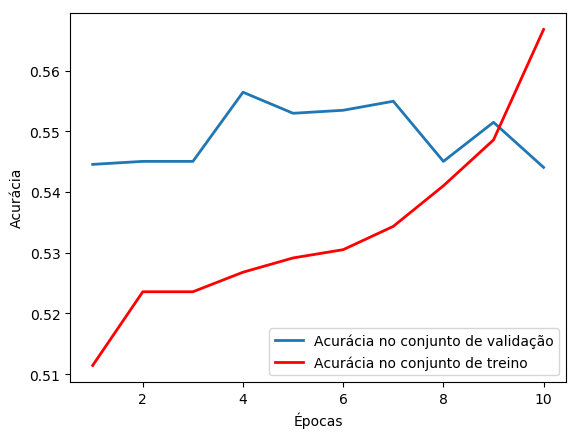

In [97]:
plt.style.use('default')
accuracy_val = plt.plot(range_epochs, val_acc, label='Acurácia no conjunto de validação')
accuracy_train = plt.plot(range_epochs, acc, label='Acurácia no conjunto de treino', color="r")
plt.setp(accuracy_val, linewidth=2.0)
plt.setp(accuracy_train, linewidth=2.0)
plt.xlabel('Épocas') 
plt.ylabel('Acurácia')
plt.legend(loc="lower right")
plt.show()